In [1]:
import spacy # text analysis
from spacy import displacy # tree plotting
import pandas as pd # data-frame manipulation
from tqdm.auto import tqdm # progress bar
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

sns.set(context='paper', style='ticks', font_scale=1) # set the plot style

Let's load the spaCy model for the English language:

In [2]:
nlp = spacy.load("en_core_web_sm")

Let's also load the book corpus:

In [3]:
harry_potter_corpus = pd.read_csv("https://raw.githubusercontent.com/" +
                                  "alexis-raymond/NLP-HP-Books/refs/" +
                                  "heads/main/data/processed/training_df.csv")

You can see that each row is storing one sentence and each sentence is annotated according to the book it is taken from.

In [4]:
harry_potter_corpus.head(10)

,sentence,book
0,A wild-looking old woman dressed all in green ...,1
1,Harry was thinking about this time yesterday a...,1
2,"He had been down at Hagrid’s hut, helping him ...",1
3,"“We’re looking for a big, old-fashioned one — ...",1
4,I forbid you to tell the boy anything!” A brav...,1
5,"“OUT!” roared Uncle Vernon, and he took both H...",1
6,Harry tore it open at once.,1
7,"“Not fast enough,” said Hagrid.",1
8,A moment’s pause — “HUFFLEPUFF!” shouted the hat.,1
9,“I’ve never even touched one.” They left the h...,1


In [5]:
harry_potter_corpus['book'].nunique()

7

## 0. Inspiration

The contents of this practical are heavily inspired by this [paper](https://www.pnas.org/doi/10.1073/pnas.2319514121), so if you want to know more about this kind of work you are encouraged to read it.

## 1. Syntax in spaCy

Besides from morphological analysis, spaCy can also be used to syntactic analyses. For instance, you can get the syntactic category of a word, or its part-of-speech (POS).

Let's analyse the sentence "John saw a man with a telescope":


In [6]:
text = "Harry eats a pizza"

Let's look at the POS and lemmas of the word-forms in this sentence:

In [7]:
for token in nlp(text):
    print(f'{token.text:{12}} {token.lemma_:{12}} {token.pos_:{12}} {token.dep_}')

Harry        Harry        PROPN        nsubj
eats         eat          VERB         ROOT
a            a            DET          det
pizza        pizza        NOUN         dobj


In [8]:
for token in nlp(text):
  print(token.text)
  print(list(token.ancestors))

Harry
[eats]
eats
[]
a
[pizza, eats]
pizza
[eats]


Besides from this, we can also look at the syntactic relationships between words in sentences using spaCy. However, it's not quite like binary trees that we saw in class. Instead, this package produces the so-called dependency trees:

In [9]:
displacy.render(nlp(text), style='dep', jupyter=True)

This types of visualizations of syntax are called dependency trees, because the visualize the relationships between heads in dependents in a phrase, instead of grupping them together into nested structures. For us, the most important thing about this type of analysis is that it can detect the subject (nsubj) of sentence, as well as the direct object (dobj).

## 2. Which character has more agency?

Let's pick three characters (Harry, Hermione and Ron) and, and find all of the sentences where they are the subject (nsubj) of a verb. First, we will need to find all the sentences that contain the words 'Harry', 'Hermione' and 'Ron'. For simplicity, we will strart by only looking at book 1.

In [10]:
book_1 = harry_potter_corpus[harry_potter_corpus['book'] == 1]
book_1.shape

(3109, 2)

In [11]:
book_1['sentence'].values[0]

'A wild-looking old woman dressed all in green had waved merrily at him once on a bus.'

Let's find all the sentences with at least one of the three characters. We will be using the pandas `str` functionality to do this:

In [63]:
characters = ['Harry',
              'Hermione',
              'Ron',
              'Neville',
              'Snape',]

sents = book_1[book_1['sentence'].str.contains('|'.join(characters))]
sents.shape

(1180, 2)

Great, 1/3 of the first book sentences contain the names of the characters that we are interested in. First, let's start by counting the percentage of sentences in which every character appears individually:

In [13]:
'rnn' in 'ton chien'

False

In [14]:
counts_frec = dict()

for sent in sents['sentence'].values:
    for char in characters:
        if char in sent:
            if char in counts_frec:
                counts_frec[char] += 1
            else:
                counts_frec[char] = 1

As you can see, Harry is one of the most frequent characters.

In [15]:
counts_frec

{'Harry': 808, 'Hermione': 171, 'Ron': 289, 'Snape': 114, 'Neville': 68}

Now, let's process those sentences with spacy, and find the sentences where one of the characters has the `nsubj` relationship with the verb. To do this, we first need to get the dependency of the subject, then look at it's ancestors, and retrieve the verb that governs it.

In [16]:
# find the sentences in which the character is nsubj, but also record the verb
subjs = []
counts_frec = dict()

for sent in tqdm(sents['sentence'].values):
    doc = nlp(sent)

    for token in doc:
        if token.text in counts_frec:
          counts_frec[token.text] += 1
        else:
          counts_frec[token.text] = 1
        if token.dep_ == 'nsubj' and token.text in characters:
          for ancestor in token.ancestors:
            if ancestor.pos_ == 'VERB':
              subjs.append((token.text, ancestor.lemma_))

  0%|          | 0/1180 [00:00<?, ?it/s]

Let's look at the results:

In [17]:
subjs[:10]

[('Harry', 'think'),
 ('Harry', 'tear'),
 ('Harry', 'take'),
 ('Hermione', 'say'),
 ('Hermione', 'squint'),
 ('Harry', 'reach'),
 ('Harry', 'raise'),
 ('Harry', 'know'),
 ('Harry', 'roll'),
 ('Ron', 'say')]

Now let's convert this to a dataframe:

In [18]:
subjects_df = pd.DataFrame(subjs, columns=['subject', 'verb'])
subjects_df.head(10)

,subject,verb
0,Harry,think
1,Harry,tear
2,Harry,take
3,Hermione,say
4,Hermione,squint
5,Harry,reach
6,Harry,raise
7,Harry,know
8,Harry,roll
9,Ron,say


Let's count the number of times each of the characters is a subject in a sentence. First, we extract the counts:co

In [19]:
counts = subjects_df['subject'].value_counts()
counts

,count
subject,
Harry,722
Ron,210
Snape,117
Hermione,111
Neville,38


Now we plot them:

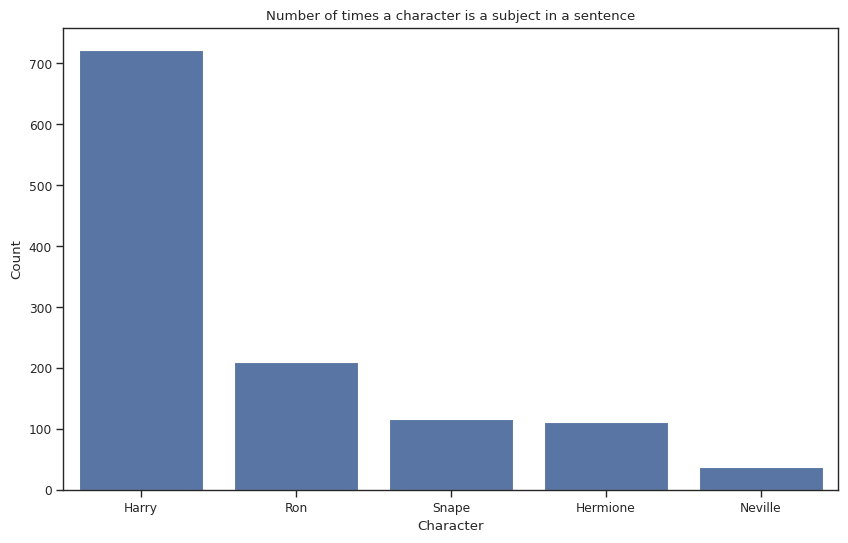

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.title('Number of times a character is a subject in a sentence')
plt.xlabel('Character')
plt.ylabel('Count')
plt.show()

While this plot is providing some information, it is a bit meaningless, since harry appears the most in all of the sentnces anyways, let's divide this number by the number of total appearances to get the percentage of `subjecthood`:

In [21]:
counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['subject', 'count']

counts_df['count_frec'] = counts_df['subject'].apply(lambda x: counts_frec[x])
counts_df['percentage_nsubj'] = counts_df['count'] / counts_df['count_frec']

counts_df.head(10)

,subject,count,count_frec,percentage_nsubj
0,Harry,722,875,0.825143
1,Ron,210,278,0.755396
2,Snape,117,124,0.943548
3,Hermione,111,171,0.649123
4,Neville,38,73,0.520548


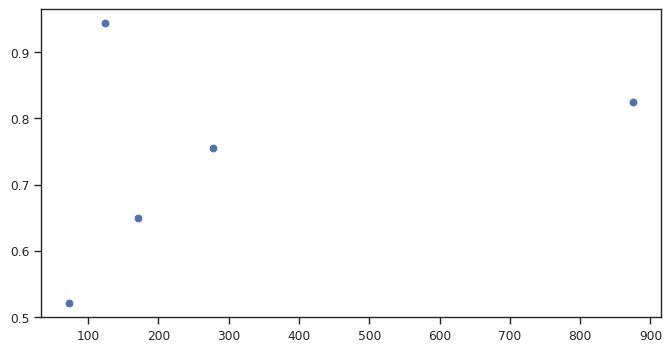

In [22]:
plt.figure(figsize=(8, 4))
plt.scatter(x=counts_df['count_frec'], y=counts_df['percentage_nsubj'])
plt.show()

Let's plot the percentages, what this plot can tell you about the first book?

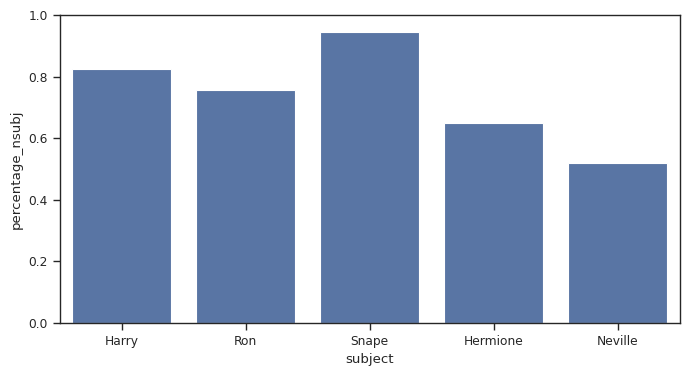

In [23]:
plt.figure(figsize=(8, 4))
sns.barplot(data=counts_df, x='subject', y='percentage_nsubj')
plt.ylim(0, 1)
plt.show()

As you can see from the `counts_df` database, we also stored the verbs corresponding to each of the three characters -- which verbs are the most frequently used with which character?

In [24]:
counts_df

,subject,count,count_frec,percentage_nsubj
0,Harry,722,875,0.825143
1,Ron,210,278,0.755396
2,Snape,117,124,0.943548
3,Hermione,111,171,0.649123
4,Neville,38,73,0.520548


In [25]:
verb_count = subjects_df.groupby('subject')['verb'].value_counts().reset_index()

In [26]:
verb_count[verb_count['subject'] == 'Harry'].head(10)

,subject,verb,count
0,Harry,say,102
1,Harry,have,30
2,Harry,look,29
3,Harry,see,26
4,Harry,think,22
5,Harry,feel,19
6,Harry,go,17
7,Harry,hear,14
8,Harry,know,14
9,Harry,get,11


## 3. Agency surplus

The interesting thing about spaCy is that we can not only detect subjects, but arso objects, i.e. participants on which the action is directed.

For instance, in the sentence "John saw a man with a telescope", "a man" or "a man with a telescope" are objects of the verb "see", depending on the interpretation.

We can see this on the dependency tree, where the objects of a verb are usually labeled as labelled `dobj`:

In [27]:
displacy.render(nlp(text), style='dep', jupyter=True)

Let's modify our code from above to also record cases in which one of the characters is an object. For that, we will add a new list `objs`, in which we will store the verbs in which the corresponding character appears as `dobj`:

In [28]:
# find the sentences in which the character is nsubj, but also record the verb
subjs = []
objs = []

for sent in tqdm(sents['sentence'].values):
    doc = nlp(sent)

    for token in doc:
        if token.dep_ == 'nsubj' and token.text in characters:
          for ancestor in token.ancestors:
            if ancestor.pos_ == 'VERB':
              subjs.append((token.text, ancestor.lemma_))
        elif token.dep_ == 'dobj' and token.text in characters:
          for ancestor in token.ancestors:
            if ancestor.pos_ == 'VERB':
              objs.append((token.text, ancestor.lemma_))

  0%|          | 0/1180 [00:00<?, ?it/s]

Now let's combine all of this into one dataframe:

In [29]:
# let's convert both lists to dataframes
subjs_df = pd.DataFrame(subjs, columns=['character', 'verb'])
objs_df = pd.DataFrame(objs, columns=['character', 'verb'])

## add columns with roles
subjs_df['role'] = 'subject'
objs_df['role'] = 'object'

# concatenate the dataframes
agency_df = pd.concat([subjs_df, objs_df])

agency_df.head(5)

,character,verb,role
0,Harry,think,subject
1,Harry,tear,subject
2,Harry,take,subject
3,Hermione,say,subject
4,Hermione,squint,subject


Now we can compute the number of times that the characters were either subjects or objects, and we can convert these values to percentages according to the total number of sentences in which every character is either a subject or an object:

In [30]:
character_summary = agency_df.groupby('character')['role'].value_counts().reset_index()
character_summary

,character,role,count
0,Harry,subject,722
1,Harry,object,91
2,Hermione,subject,111
3,Hermione,object,9
4,Neville,subject,38
5,Neville,object,11
6,Ron,subject,210
7,Ron,object,25
8,Snape,subject,117
9,Snape,object,13


Now let's convert the counts into percentages by summing them for each character and then dividing each entry by this sum:

In [43]:
character_summary['percentage'] = character_summary.groupby('character')['count'].transform(lambda x: x / x.sum())
character_summary.head(10)

,character,role,count,percentage,agency_surplus
0,Harry,subject,722,0.888069,NaN
1,Harry,object,91,0.111931,NaN
2,Hermione,subject,111,0.925000,NaN
3,Hermione,object,9,0.075000,NaN
4,Neville,subject,38,0.775510,NaN
5,Neville,object,11,0.224490,NaN
6,Ron,subject,210,0.893617,NaN
7,Ron,object,25,0.106383,NaN
8,Snape,subject,117,0.900000,NaN
9,Snape,object,13,0.100000,NaN


Now compute the agency surplus by applying the following equation to each character:

$$\text{Agency surplus} = count(object) - count(subject)$$

If this value is positive, the character is more frequently and object, but if it's negative, the character is more likely to be a subject, i.e. an active participant.

In [58]:
character_summary.query('character == "Hermione"')['percentage'].values[0]

0.925

In [59]:
# subtracgt object - subject for each character
a_surplus = []

for c in characters:
    a_surplus.append((c, character_summary.query(f'character == "{c}"')['percentage'].values[1]\
                       - character_summary.query(f'character == "{c}"')['percentage'].values[0]))

In [60]:
a_surplus

[('Harry', -0.7761377613776137),
 ('Hermione', -0.8500000000000001),
 ('Ron', -0.7872340425531914),
 ('Neville', -0.5510204081632653),
 ('Snape', -0.8)]

Finaly, can you extend this analysis to all of the 6 books and compare the agency surprlus of each character? To do this, you would need to write a function that takes the set of sentences in a book, and returns the character info with their corresponding agency surplus.

Let's start by writing a function to analyze each book individually and record the agency surplus.

In [65]:
def analyze_book(sents, characters):

  subjs = []
  counts_frec = dict()

  for sent in tqdm(sents['sentence'].values):
      doc = nlp(sent)

      for token in doc:
          if token.text in counts_frec:
            counts_frec[token.text] += 1
          else:
            counts_frec[token.text] = 1
          if token.dep_ == 'nsubj' and token.text in characters:
            for ancestor in token.ancestors:
              if ancestor.pos_ == 'VERB':
                subjs.append((token.text, ancestor.lemma_))
          elif token.dep_ == 'dobj' and token.text in characters:
            for ancestor in token.ancestors:
              if ancestor.pos_ == 'VERB':
                objs.append((token.text, ancestor.lemma_))

  # let's convert both lists to dataframes
  subjs_df = pd.DataFrame(subjs, columns=['character', 'verb'])
  objs_df = pd.DataFrame(objs, columns=['character', 'verb'])

  ## add columns with roles
  subjs_df['role'] = 'subject'
  objs_df['role'] = 'object'

  # concatenate the dataframes
  agency_df = pd.concat([subjs_df, objs_df])

  character_summary = agency_df.groupby('character')['role']\
    .value_counts().reset_index()
  character_summary['percentage'] = character_summary\
    .groupby('character')['count'].transform(lambda x: x / x.sum())

  # subtracgt object - subject for each character
  a_surplus = []

  for c in characters:
      a_surplus.append((c, character_summary.query(f'character == "{c}"')['percentage'].values[1]\
                        - character_summary.query(f'character == "{c}"')['percentage'].values[0]))

  return a_surplus


Now we can apply our function to each book and store the results in a list.

In [66]:
characters = ['Harry',
              'Hermione',
              'Ron',
              'Neville',
              'Snape',]


agency_spls = []

for i in range(1, 7):
  book_i = harry_potter_corpus[harry_potter_corpus['book'] == i]
  agency_spls.append(analyze_book(book_i, characters))

  0%|          | 0/3109 [00:00<?, ?it/s]

  0%|          | 0/3443 [00:00<?, ?it/s]

  0%|          | 0/4539 [00:00<?, ?it/s]

  0%|          | 0/7287 [00:00<?, ?it/s]

  0%|          | 0/8338 [00:00<?, ?it/s]

  0%|          | 0/5754 [00:00<?, ?it/s]

Finally, let's store it as a dataframe with

In [72]:
# Initialize an empty list to hold dataframes for each book
frames = []

# Populate the dataframes
for i, book_data in enumerate(agency_spls, start=1):
    book_df = pd.DataFrame(book_data, columns=['character', 'agency_surplus'])
    book_df['book'] = i
    frames.append(book_df)

# Concatenate all the book dataframes
spls_df = pd.concat(frames, ignore_index=True)

spls_df.head(10)

,character,agency_surplus,book
0,Harry,-0.597345,1
1,Hermione,-0.720930,1
2,Ron,-0.615385,1
3,Neville,-0.266667,1
4,Snape,-0.636364,1
5,Harry,-0.493997,2
6,Hermione,-0.640449,2
7,Ron,-0.569378,2
8,Neville,-0.384615,2
9,Snape,-0.411765,2


Let's first look at the average agency surplus for each character over all of the books. It seems that all the characters have rougly the same subjectivity:

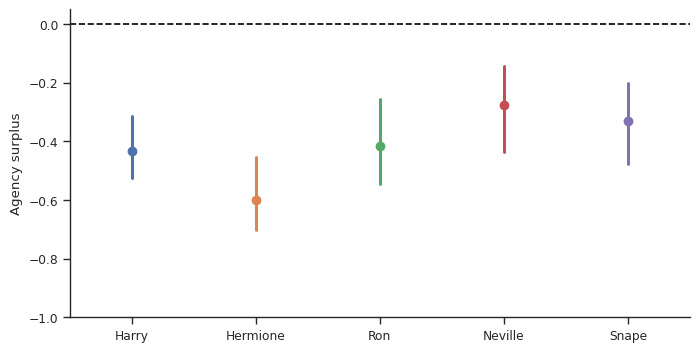

In [112]:
plt.figure(figsize=(8, 4))
sns.pointplot(data=spls_df, x='character', y='agency_surplus',
              linestyle='none', hue='character',)
plt.xlabel('')
plt.ylabel('Agency surplus')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-1, 0.05)
sns.despine()
plt.show()

Now let's look at the change of the agency surplus for each character in all of the 7 books:

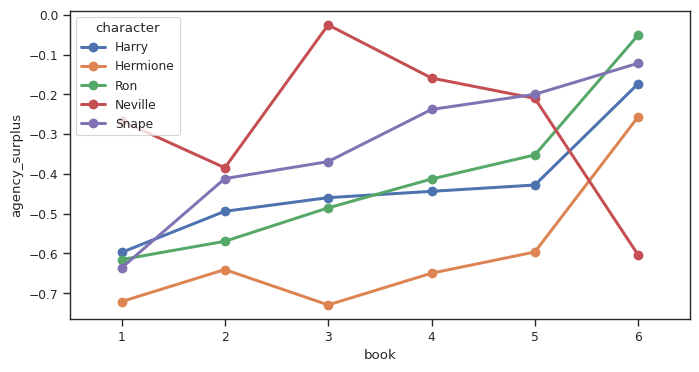

In [115]:
plt.figure(figsize=(8, 4))
sns.pointplot(data=spls_df, x='book', y='agency_surplus', hue='character',)
plt.show()

For some reasons all of the characters except for Neville become les agentive with time -- what do you think is the reason for that?
